In [196]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad, quad_vec, cumulative_trapezoid, simpson
from tqdm import tqdm
import timeit

In [197]:
"""
Constants
"""
# --> Pulse <--
wl = 0.057                   # au
epsilon = 0
intensity = 1e13 / 3.51e16     # au
phi = 0
Nc = 20
T = Nc * 2*np.pi/wl

F0 = np.sqrt(intensity)
A0 = F0 / wl

Up = A0**2 * 0.25

# def envelope(t) : 
#     global wl, Nc, T
#     return np.sin(np.pi*t/T)**2

def envelope(t) : 
    return 1

# --> System <--
E0 = -0.5                       # au


In [198]:
def time_evolution(tp, t0) : 
    global E0
    return np.exp( -1j*E0*(tp-t0) ) 

def A(t: np.array) : 
    global A0, epsilon, phi, Nc
    prefac = A0 * envelope(t) / ( np.sqrt( 1 + epsilon**2) )

    vec = np.stack([
                    np.zeros_like(t), 
                    epsilon*np.sin(wl*t+phi),
                    np.cos(wl*t+phi)
    ], axis=0)

    # returns: (3, len(t))
    return prefac * vec

def get_alpha_and_betas(tps: np.array, t0: float, dt: float) : 
    alpha_list = np.zeros(shape=(len(tps),3,))
    beta_list = np.zeros_like(tps)

    for i, tp in enumerate(tps) : 
        tgrid = np.arange(t0, tp+0.2*dt, dt)
        A_of_ts = A(tgrid)
        A2_of_ts = np.sum(A_of_ts**2, axis=0)  # shape: (len(tps),)

        alpha = simpson(y=A_of_ts, x=tgrid)
        # alpha = np.sum(A_of_ts*dt,axis=0)
        beta = simpson(y=A2_of_ts, x=tgrid)
        # beta = np.sum(A2_of_ts*dt,axis=0)

        #print(beta)
        
        alpha_list[i] = alpha
        beta_list[i] = beta

    # returns: 
    # alpha_list: (len(tps),3)
    # beta_list: (len(tps),)
    return (alpha_list, beta_list)

def ground_state_fourier(k: np.array) : 
    return 2**(5/2)/(2*np.pi) * 1/( np.dot(k,k) +1)**2

def matrix_element(t: float, t0: float, k_y_grid: np.array,k_z_grid: np.array, N: int,dt: float) : 
    # Time grid
    ts = np.arange(t0, t+0.2*dt, dt)
    # Precompute alpha and beta
    alphas, betas = get_alpha_and_betas(ts, t0, dt)
    A_tgrid = A(ts) # each column is Ax(t1), Ay(t1), Az(t1)

    # k-vectors

    result = np.zeros_like(k_y_grid)

    for i in tqdm(range(np.shape(k_y_grid)[1])) : 
        for j in range(np.shape(k_z_grid)[0]) : 
            k_y = k_y_grid[j,i]
            k_z = k_z_grid[j,i]
            k_vector = np.array([0.0, k_y, k_z])
            k2 = k_vector.dot(k_vector)
            
            prod = np.dot(A_tgrid.transpose(), k_vector)
            if i == 0 and j == 0:
                print(alphas.shape)
                print(ts.shape)
                print(np.dot(alphas, k_vector).shape)
            
            state = np.exp( 1j*0.5*k2*(ts-t0) 
                           + 1j*np.dot(alphas, k_vector) 
                           + 1j*0.5*betas ) * time_evolution(ts, t0)

            integrand = prod * state

            # Do simpson integration
            integral = simpson(y=integrand, x=ts)

            res = -1j * ground_state_fourier(k_vector) * integral

            result[j,i] = np.abs(res)**2
    
    return A_tgrid, result     


In [199]:
# Time grid for precomputations
N = 10
t0 = 0.0
ts = np.linspace(t0, T, N)
dt = ts[1] - ts[0]

A_ts = A(ts)
k = np.array([0.0, 1.0, 2.0])
A_ts_t = A_ts.transpose()
print(np.dot(A_ts_t, np.array([1,1,1])))


alphas, betas = get_alpha_and_betas(ts, t0, dt=T/100)
print(alphas)
#print(betas)

[ 0.29612262  0.05142115 -0.27826424 -0.14806131  0.22684309  0.22684309
 -0.14806131 -0.27826424  0.05142115  0.29612262]
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  5.02472698e+00]
 [ 0.00000000e+00  0.00000000e+00  3.10545206e+00]
 [ 0.00000000e+00  0.00000000e+00 -2.78438005e+00]
 [ 0.00000000e+00  0.00000000e+00 -5.02472698e+00]
 [ 0.00000000e+00  0.00000000e+00 -5.19505412e-01]
 [ 0.00000000e+00  0.00000000e+00  5.02472698e+00]
 [ 0.00000000e+00  0.00000000e+00  3.62495747e+00]
 [ 0.00000000e+00  0.00000000e+00 -5.34579898e+00]
 [ 0.00000000e+00  0.00000000e+00 -3.13971071e-13]]


In [200]:

# threshold = 200*np.sqrt(Up)
threshold= 2.

theta = np.linspace(0,2*np.pi,500)
Es = np.linspace(0,threshold**2,300)

theta_grid,Es_grid = np.meshgrid(theta,Es)
kgrid = np.sqrt(2*Es_grid)
ky_grid = kgrid*np.cos(theta_grid)
kz_grid = kgrid*np.sin(theta_grid)

A_ts,matrix = matrix_element(t=T, t0=0.0, k_y_grid=ky_grid,k_z_grid=kz_grid, N=200,dt=2*np.pi/wl/500)

  0%|          | 0/500 [00:00<?, ?it/s]

(10001, 3)
(10001,)
(10001,)


100%|██████████| 500/500 [08:15<00:00,  1.01it/s]


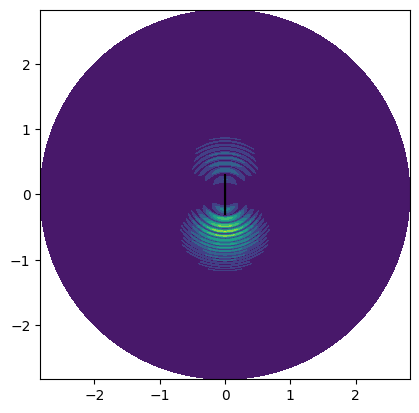

In [201]:
# Z,Y = np.meshgrid(k_zs, k_ys)
# print(Y)

fig, ax = plt.subplots()

ax.contourf(ky_grid, kz_grid, matrix)
ax.plot(-A_ts[1], -A_ts[2], 'k-')
ax.set_aspect("equal")

# vinkler = np.linspace(0,2*np.pi,100)
# for n in range(36,40):
#     energy = 2*(-E0-Up+n*wl)
#     if energy <0:
#         continue 
#     førstepeak = np.sqrt(energy)
#     plt.plot(førstepeak*np.cos(vinkler),førstepeak*np.sin(vinkler))



0.057 0.02192215180827061 -0.5 0.001249562653071425


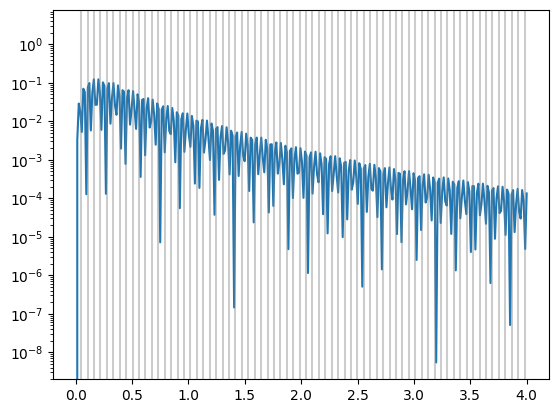

In [202]:
from scipy.signal import find_peaks
dtheta = np.diff(theta)[0]
dpdE = np.sum(matrix*dtheta*kgrid,axis=1)

plt.plot(Es,dpdE)
plt.yscale("log")
# plt.xlim(1,20)

ns = np.arange(0,100,1)
expect_peaks = (E0-Up)+ns*wl
peaks = find_peaks(dpdE,distance = 20)[0]
# plt.vlines(Es[peaks],0,800,colors="red",alpha=0.4)
idx = np.logical_and(expect_peaks<4,expect_peaks>0.)
plt.vlines(expect_peaks[idx],0,800,colors="grey",alpha=0.4)
# plt.vlines(2.0,0,1,color="k")
# print(Up)
# plt.vlines(-(E0-Up),0,800,colors="green",alpha=0.4)

# print(Es[peaks]-expect_peaks[idx]+wl)
# print(np.mean(Es[peaks]-expect_peaks[idx]+wl))
print(wl,Up,E0,wl*Up)

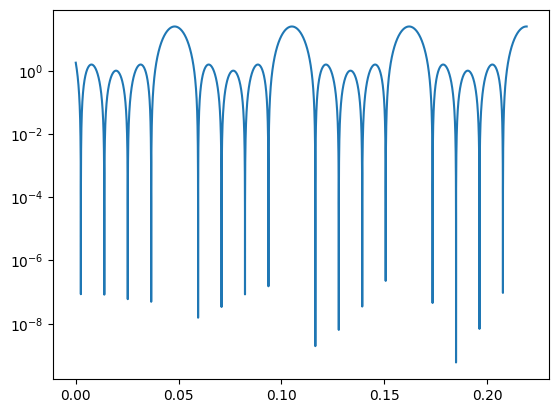

In [203]:

xs = np.linspace(0,10*Up,100000)
plt.plot(xs,np.sin((xs+Up-E0)*np.pi*5/wl)**2/np.sin((xs+Up-E0)*np.pi/wl)**2)
plt.yscale("log")
# ns = np.arange(10,30,1)
# expect_peaks = (E0-Up)+(ns)*wl
# plt.vlines(expect_peaks,0,25,colors="grey")

In [204]:



A_ts_1cycle,matrix_1cycle = matrix_element(t=2*np.pi/wl, t0=0.0, k_y_grid=ky_grid,k_z_grid=kz_grid, N=200,dt=2*np.pi/wl/300)

  0%|          | 2/500 [00:00<00:37, 13.46it/s]

(301, 3)
(301,)
(301,)


100%|██████████| 500/500 [00:31<00:00, 15.68it/s]


(0.0, 3.0)

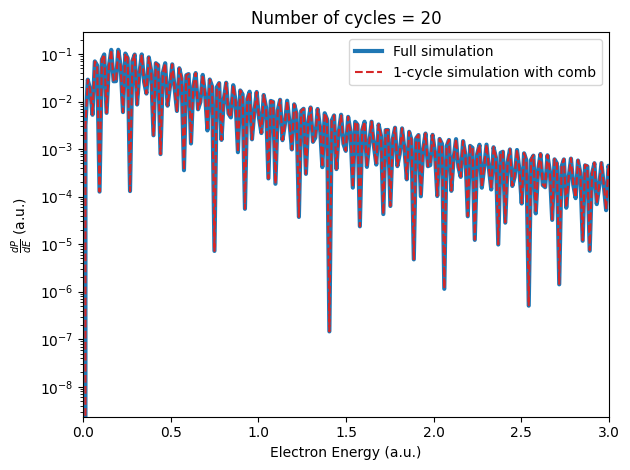

In [223]:
dtheta = np.diff(theta)[0]
dpdE_formel = np.sum(matrix_1cycle*dtheta*kgrid,axis=1)*np.sin((Es+Up-E0)*np.pi*Nc/wl)**2/np.sin((Es+Up-E0)*np.pi/wl)**2

fig, ax = plt.subplots(tight_layout=True)
ax.plot(Es,dpdE,label="Full simulation",lw=3)
ax.plot(Es,dpdE_formel,"--",color="tab:red",label="1-cycle simulation with comb")
ax.set_title(f"Number of cycles = {Nc}")
ax.set_yscale("log")
ax.set_xlabel("Electron Energy (a.u.)")
ax.set_ylabel(r"$\frac{dP}{dE}$ (a.u.)")
ax.legend()
ax.set_xlim(0,3)

# plt.xlim(1,20)


# ns = np.arange(0,100,1)
# expect_peaks = (E0-Up)+ns*wl
# idx = np.logical_and(expect_peaks<3.,expect_peaks>0.)
# plt.vlines(expect_peaks[idx],0,800,colors="grey",alpha=0.4)